In [1]:
import time
import numpy as np
import pandas as pd
import argparse
import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch import nn

from models import BatteryGPT
from data_provider.data_factory import data_provider


## 验证模型

In [2]:
filetime = time.strftime('%Y%m%d%H%M', time.localtime())
parser = argparse.ArgumentParser(description='Time-LLM')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='Battery', help='model id')
parser.add_argument('--model_comment', type=str, required=False, default='none', help='prefix when saving test results')
parser.add_argument('--model', type=str, required=False, default='BatteryGPTv0',
                    help='model name, options: [Autoformer, DLinear]')
parser.add_argument('--seed', type=int, default=42, help='random seed')

# data loader
parser.add_argument('--data', type=str, required=False, default='mbatdata', help='dataset type')
parser.add_argument('--root_path', type=str, default='./dataset/my', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='trimmed_LX3_ss0_se100_cr05_C_V_T_vs_CE.csv', help='data file')
parser.add_argument('--drop_bid', type=int, default=0)
parser.add_argument('--cutting_rate', type=float, default=1.2)
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; '
                            'M:multivariate predict multivariate, S: univariate predict univariate, '
                            'MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--loader', type=str, default='modal', help='dataset type')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, '
                            'options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], '
                            'you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./cache/', help='location of model checkpoints')
parser.add_argument('--logger', type=str, default='./logs', help='log folder')
parser.add_argument('--on_server', type=bool, default=False)

# forecasting task
parser.add_argument('--seq_limit', type=int, default=48, help='raw sequence length')
parser.add_argument('--seq_len', type=int, default=18, help='input sequence length')
parser.add_argument('--label_len', type=int, default=9, help='start token length')
parser.add_argument('--pred_len', type=int, default=30, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

# model define
parser.add_argument('--enc_in', type=int, default=11, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=16, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=32, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--patch_len', type=int, default=8, help='patch length')
parser.add_argument('--stride', type=int, default=4, help='stride')
parser.add_argument('--prompt_domain', type=int, default=0, help='')

# optimization
parser.add_argument('--num_workers', type=int, default=1, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--align_epochs', type=int, default=10, help='alignment epochs')
parser.add_argument('--batch_size', type=int, default=8, help='batch size of train input data')
parser.add_argument('--eval_batch_size', type=int, default=8, help='batch size of model evaluation')
parser.add_argument('--patience', type=int, default=10, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.2, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--llm_layers', type=int, default=6)
parser.add_argument('--percent', type=int, default=100)

args = parser.parse_args(args=[])
accelerator = Accelerator(mixed_precision='bf16', device_placement=False)

# 还原训练参数
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1

args.batch_size = 1


In [4]:
# 读取数据
# train_data, train_loader = data_provider(args, 'train')
# vali_data, vali_loader = data_provider(args, 'val')
test_data, test_loader = data_provider(args, 'test')

data-2 load completed: (27471,)


In [5]:
# 读取模型
sd_202403142139 = r'./cache\long_term_forecast_Battery_BatteryGPT_masked_battery_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-BatteryGPT-Masked_battery\checkpoint'
sd_202403151801 = r'cache\long_term_forecast_Battery_BatteryGPT_masked_battery_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-BatteryGPT-Masked_battery\202403151801_checkpoint'
model = BatteryGPT.Model(args).float()
model.load_state_dict(torch.load(sd_202403151801))

test_loader, model = accelerator.prepare(
    test_loader, model)


In [6]:
# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

318867546

In [7]:
# 验证模型
model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

y = []
yhat = []
model.eval()
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    print('batch %d' %i)
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs = outputs[:, -args.pred_len:, f_dim:]
    batch_y = batch_y[:, -args.pred_len:, f_dim:]

    pred = outputs.detach().cpu().numpy()
    true = batch_y.detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    y.append(true)
    yhat.append(pred)
    
    if i == 0:
        break

batch 0
batch 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 6.82 GiB is allocated by PyTorch, and 425.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
y1 = np.array(y)
yhat1 = np.array(yhat)

print(y1.shape)
print(yhat1.shape)

(1, 1, 30, 1)
(1, 1, 30, 1)


In [11]:
y1 = np.array(y).squeeze(-1)
yhat1 = np.array(yhat).squeeze(-1)

# print(y1.shape)
# print(yhat1.shape)

# 将前两个维度作为 MultiIndex
index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
# 将数组转换为 DataFrame
df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
# 将前两个维度作为 MultiIndex
index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
# 将数组转换为 DataFrame
df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

df = pd.concat([df1, df2], axis=1)
display(df)

# df.to_csv('./ana_model_pred.csv')


y      yhat
batch seq id                    
0     0   0  -0.534874 -0.558594
          1  -0.509245 -0.531250
          2  -0.483616 -0.503906
          3  -0.457986 -0.472656
          4  -0.432770 -0.447266
          5  -0.407141 -0.419922
          6  -0.381512 -0.386719
          7  -0.355882 -0.359375
          8  -0.330253 -0.330078
          9  -0.304624 -0.302734
          10 -0.278994 -0.273438
          11 -0.253365 -0.244141
          12 -0.227735 -0.215820
          13 -0.202106 -0.188477
          14 -0.176477 -0.159180
          15 -0.150434 -0.131836
          16 -0.124805 -0.105469
          17 -0.099175 -0.075684
          18 -0.073133 -0.049561
          19 -0.047503 -0.023438
          20 -0.021461  0.001144
          21  0.004582  0.026001
          22  0.030212  0.048584
          23  0.056254  0.073242
          24  0.082297  0.094238
          25  0.108340  0.116699
          26  0.134796  0.133789
          27  0.160839  0.153320
          28  0.187708  0.171875
          29  0.188121  0.185547

In [10]:
df = pd.read_csv('./ana_model_pred.csv')
df = df.set_index(['batch', 'seq'])
df.index.unique()

MultiIndex([(  0, 0),
            (  1, 0),
            (  2, 0),
            (  3, 0),
            (  4, 0),
            (  5, 0),
            (  6, 0),
            (  7, 0),
            (  8, 0),
            (  9, 0),
            ...
            (159, 0),
            (160, 0),
            (161, 0),
            (162, 0),
            (163, 0),
            (164, 0),
            (165, 0),
            (166, 0),
            (167, 0),
            (168, 0)],
           names=['batch', 'seq'], length=169)

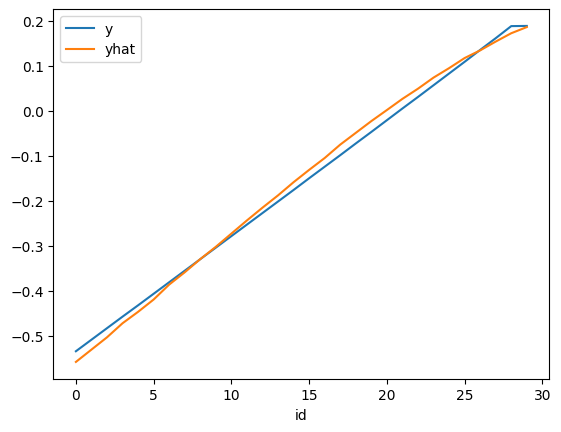

In [12]:
df.loc[(0,0), ['y', 'yhat']].plot()
plt.show()

In [19]:
a = [[i for i in range(5)] for j in [i for i in range(5)]]
print(a)
isinstance(np.average(a, axis=None), list)

[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]


False